In [1]:
from common import *
from search.imports import *
from search.search import *
from search.manager import ModelManager
from features.bank import TP

from features import Features

In [2]:
import globals as top_imports
top_imports.use_M = False
from given import *

In [3]:
def get_name(q):
    return q[q.index('<')+1:q.index('>')]

In [4]:
sharpe = lambda x: x.mean()/x.std(ddof=0)

 stupid things i have to load to query bigF

In [5]:
F, P = pd.read_pickle(the_data/'saves/train_5fixedsince+1.32.pkl')
setup_P(F=F,P=P)
bigF = Features(F=F, P=P)

set the models to blend

In [6]:
q_ = []
q_ += [getattr(TP,x) for x in 's20 s21 s22 s00 s10 s11'.split()]
q_ += [getattr(TP,x) for x in 'IKGCover TryIt IKGCoverTenDraw IKGCoverThree IKGCoverThreeVP1 IKGCoverThreeMoreShort'.split()]

In [7]:
qq_ = []
qq_ += [TP.PairFiveShortVP1_1_0_0_NoCorr]

Load up the models

In [8]:
DIR = '/big/data/nouveau/'

In [9]:
ans = []
nbests = []

mm = ModelManager(DIR+'flat')
for q in q_:
    name = get_name(q)
    f, _ = bigF.query_solo(q)
    fi = mm.F.i(Feats=f)
    pm = mm.iPM(fi, 0)
    nbest = pm.get('Results', i=0).nbest
    guy = pm.get('Answers', i=0)
    res = pd.concat([guy[i][0] for i in range(len(guy)-1)]+guy[-1][1:], axis=0)
    ans.append(res)
    nbests.append(nbest)

mm = ModelManager(DIR+'vp10')
for q in q_:
    name = get_name(q)
    f, _ = bigF.query_solo(q)
    fi = mm.F.i(Feats=f)
    pm = mm.iPM(fi, 0)
    nbest = pm.get('Results', i=0).nbest
    guy = pm.get('Answers', i=0)
    res = pd.concat([guy[i][0] for i in range(len(guy)-1)]+guy[-1][1:], axis=0)
    ans.append(res)
    nbests.append(nbest)
    
Pair = O(lo=(.55, 500), hi=None, repeat=2)
tag = f'pair,{Pair.lo},{Pair.hi},{Pair.repeat}'
mm = ModelManager(DIR+tag)
for q in qq_:
    name = get_name(q)
    fi = 0
    pm = mm.iPM(fi, 0)
    nbest = pm.get('Results', i=0).nbest
    guy = pm.get('Answers', i=0)
    res = pd.concat([guy[i][0] for i in range(len(guy)-1)]+guy[-1][1:], axis=0)
    ans.append(res)
    nbests.append(nbest)

In [10]:
names = ['a'+get_name(q) for q in q_] + ['m'+get_name(q) for q in q_] + ['p'+get_name(q) for q in qq_]

In [11]:
def get_daily(df):
    WEIGHT = 'flat_weight' if 'flat_weight' in df else 'vp10_weight'
    df['trade'] = (df.target*2-1) * df[WEIGHT] * df.guess.fillna(0)
    return df.groupby('time')[['trade']].sum()

In [12]:
# p = P[P.quarter>=2010]
d = None
for name, res in zip(names, ans):
    if d is None:
        d = get_daily(res).rename(columns={'trade':name})
    else:
        d[name] = get_daily(res).iloc[:,0]

In [13]:
paircol = 'pPairFiveShortVP1_1_0_0_NoCorr'
cols = ['m'+x for x in 's20 s21 s22 s00 s10 s11 IKGCover TryIt IKGCoverTenDraw IKGCoverThreeMoreShort'.split()]
cols += ['a'+x for x in 's20 s21 s22 s00 s10 s11 IKGCover TryIt IKGCoverTenDraw IKGCoverThreeMoreShort'.split()]
d = d['ms10 as21 aTryIt aIKGCoverThreeMoreShort'.split() + [paircol]]

In [14]:
def make_values(d, lo, hi=2017):
    dt = pd.Series(d.index)
    qt = dt.dt.year+(dt.dt.quarter-1)/4
    return d[((lo<=qt)&(qt<hi)).values].values

In [437]:
_DO_IT_ = True

In [439]:
if _DO_IT_:
    n = 1_000_000
    dd = make_values(d, 2010, 2015.5)
    cc = np.random.exponential(size=(n,dd.shape[1]))
    cc /= cc.sum(axis=1)[:,None]
    scores = [sharpe(dd@c) for c in cc]
    ibest = sorted(range(n), key=lambda i: scores[i], reverse=True)
_DO_IT_ = False

In [440]:
list(zip(d.columns, cc[ibest[0]]))

[('ms10', 0.65975414084313266),
 ('as21', 0.13023938367567811),
 ('aTryIt', 0.07751045616457887),
 ('aIKGCoverThreeMoreShort', 0.045147656168428356),
 ('pPairFiveShortVP1_1_0_0_NoCorr', 0.087348363148181923)]

In [441]:
%matplotlib inline
canvas(18,6)

0.71172844253


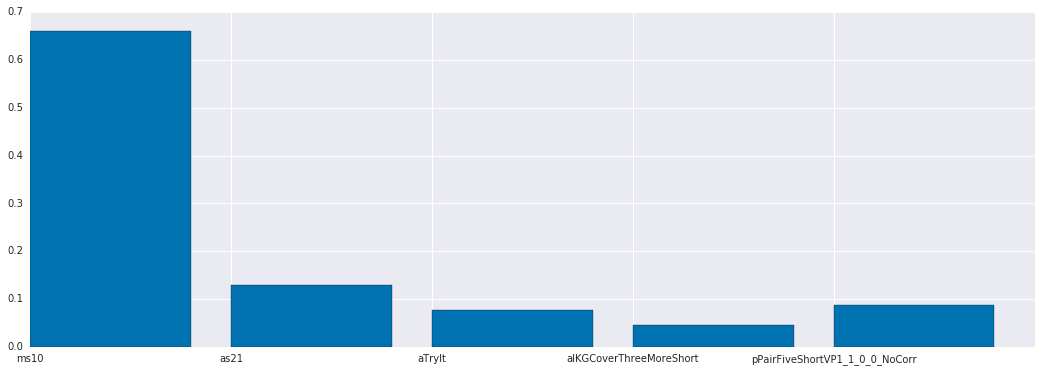

In [442]:
k = 0
print(scores[ibest[k]])
plt.bar(np.arange(d.shape[1]), tick_label=d.columns, height=cc[ibest[k]]);

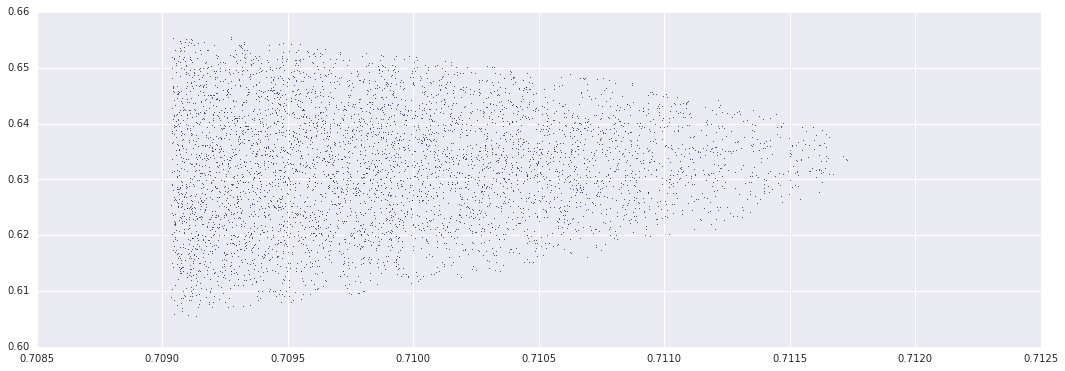

In [443]:
guys = np.asarray([[scores[i], sharpe(make_values(d, 2015.5) @ cc[i])] for i in ibest[:5000:]])
plt.scatter(guys[:,0], guys[:,1], s=.3);

In [271]:
guys[0,1] # with pair

0.64020323924773304

In [365]:
guys[0,1] # with pair *2

0.63068309044412763

In [286]:
guys[0,1] # without pair

0.63993263535217426

In [320]:
guys[0,1] # without pair *2

0.63815829216489883

In [343]:
guys[0,1] # without pair without IKGCover

0.64196011246990636

In [333]:
guys[0,1] # without mo stuff

0.6374382126186261

In [354]:
guys[0,1] # only the FOUR

0.63703449615890917

In [401]:
guys[0,1] # only the FOUR *2

0.63822294856166173

# COPY PRODUCTION

In [19]:
def copy_production(names, nbests):
    nl = '\\n'
    for name, nbest in zip(names, nbests):
        ctor = getattr(TP, name[1:])
        if name[0] != 'p': # single
            paramsUse = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,
                             min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0)
            features = f'features = {stringify_list(bigF.query_solo(ctor)[0])}'
        else:
            paramsUse = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,
                             min_sum_hessian_in_leaf=10,lambda_l1=0,lambda_l2=0)
            _f = bigF.query_solo(ctor)[0]
            features = '\n        '.join(x+'_features = '+stringify_list(a) for x,a in zip(['copy','diff','plus','corr'],_f))
        paramsUse.update({'num_iterations': nbest})
        tag = 'vp10' if name[0]=='m' else 'flat'
        guy = f'''\
    class {name}(NamedO()):
        {features}
        feats_ctor = {repr(ctor)}
        train_on = fullhouse
        weight = '{tag}_weight'
        params = {str(O(paramsUse)).replace('<>','dict').replace(' ','')}
            '''
        print(guy[:guy.rindex('\n')])

In [20]:
copy_production(names, nbests)

    class as20(NamedO()):
        features = ["dayOfYear","oo15","aoo15","vp1dd15","volatility60","vp60","fracRecordedDaysSince21","oo10MaxSince21","oo10Drawdown5Since21","oo10Drawdown10Since21","oo10Drawdown20Since21","oo10MaxSince21{5}","oo10MinSince21","oo10MinSince21{5}","(oo-aoo)10MaxSince21","(oo-aoo)10Drawdown5Since21","(oo-aoo)10Drawdown10Since21","(oo-aoo)10Drawdown20Since21","(oo-aoo)10MaxSince21{5}","(oo-aoo)10MinSince21","(oo-aoo)10MinSince21{5}","oo10MaxSince62","oo10Drawdown5Since62","oo10Drawdown10Since62","oo10Drawdown20Since62","oo10MaxSince62{5}","oo10MinSince62","oo10MinSince62{5}","(oo-aoo)10MaxSince62","(oo-aoo)10Drawdown5Since62","(oo-aoo)10Drawdown10Since62","(oo-aoo)10Drawdown20Since62","(oo-aoo)10MaxSince62{5}","(oo-aoo)10MinSince62","(oo-aoo)10MinSince62{5}","oo10MaxSince250","oo10Drawdown5Since250","oo10Drawdown10Since250","oo10Drawdown20Since250","oo10MaxSince250{5}","oo10MinSince250","oo10MinSince250{5}","(oo-aoo)10MaxSince250","(oo-aoo)10Drawdown5Since250"

    class as10(NamedO()):
        features = ["cc","oo","dayOfYear","dayOfWeek","volatility60","oo{0/1}","oo{1/2}","oo{1}","oo{2}","(cc-acc){0/1}","(cc-acc){1/2}","(cc-acc){1}","(cc-acc){2}","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1Drawdown(10-5)Since21","oo1MinSince21","oo1MinSince21{5}","oo10Since21","oo10MaxSince21","oo10Drawdown1Since21","oo10Drawdown5Since21","oo10Drawdown10Since21","oo10Drawdown(10-5)Since21","oo10MinSince21","oo10MinSince21{5}","(oo-aoo)10Since21","(oo-aoo)10MaxSince21","(oo-aoo)10Drawdown1Since21","(oo-aoo)10Drawdown5Since21","(oo-aoo)10Drawdown10Since21","(oo-aoo)10Drawdown(10-5)Since21","(oo-aoo)10MinSince21","(oo-aoo)10MinSince21{5}","vp1dd1Since21","vp1dd1MaxSince21{5}","vp1dd1Drawup(20-10)Since21","vp1dd1MinSince21{20}","vp5dd1Since21","vp5dd1MaxSince21{5}","vp5dd1Drawup(20-10)Since21","vp5dd1MinSince21{20}","vp10dd1Since21","vp10dd1MaxSince21{5}","vp10dd1Drawup(20-10)Since21","vp10dd1MinSince21{20

    class aTryIt(NamedO()):
        features = ["oo","aoo","dayOfYear","dayOfWeek","vp10","oo5","oo10","oo15","aoo5","aoo10","aoo15","vp1dd5","vp1dd10","vp1dd15","volatility60","vp20","oo(10-5)","oo(15-10)","oo(20-15)","oo(15-5)","oo(20-10)","oo(20-5)","aoo(10-5)","aoo(15-10)","aoo(20-15)","aoo(15-5)","aoo(20-10)","aoo(20-5)","vp1dd(10-5)","vp1dd(15-10)","vp1dd(20-15)","vp1dd(15-5)","vp1dd(20-10)","vp1dd(20-5)","oo{1}","oo{2}","(oo-aoo){1}","(oo-aoo){2}","(oo-cc){1}","(oo-cc){2}","(aoo-acc){1}","(aoo-acc){2}","vp1dd","vp1dd{1}","vp1dd{2}","fracRecordedDaysSince21","oo1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1Drawdown20Since21","oo1Drawdown(10-5)Since21","oo1Drawdown(20-10)Since21","oo1MinSince21","aoo1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1Drawdown20Since21","aoo1Drawdown(10-5)Since21","aoo1Drawdown(20-10)Since21","aoo1MinSince21","oo10Since21","oo10Drawdown5Since21","oo10Drawdown10Since21","oo10Drawdown20Since21","oo10Drawdown(10-5)Since21","oo10

    class aIKGCoverThree(NamedO()):
        features = ["assetCodeId","volume","cc","oo","acc","aoo","oo15","aoo15","af","it","rr","af{1}","it{1}","(it,af,it{1},aoo,acc){0/1}","(it{1},af{1},it{2},aoo{1},acc{1}){0/1}","(it,af,it{1},aoo,acc){0/2}","(it{1},af{1},it{2},aoo{1},acc{1}){0/2}","(it,af,it{1},aoo,acc){0/3}","(it{1},af{1},it{2},aoo{1},acc{1}){0/3}","(it,af,it{1},aoo,acc){0/4}","(it{1},af{1},it{2},aoo{1},acc{1}){0/4}","(it,af,it{1},aoo,acc){1/2}","(it{1},af{1},it{2},aoo{1},acc{1}){1/2}","(it,af,it{1},aoo,acc){1/3}","(it{1},af{1},it{2},aoo{1},acc{1}){1/3}","(it,af,it{1},aoo,acc){1/4}","(it{1},af{1},it{2},aoo{1},acc{1}){1/4}","(it,af,it{1},aoo,acc){2/3}","(it{1},af{1},it{2},aoo{1},acc{1}){2/3}","(it,af,it{1},aoo,acc){2/4}","(it{1},af{1},it{2},aoo{1},acc{1}){2/4}","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown1

    class ms20(NamedO()):
        features = ["dayOfYear","oo15","aoo15","vp1dd15","volatility60","vp60","fracRecordedDaysSince21","oo10MaxSince21","oo10Drawdown5Since21","oo10Drawdown10Since21","oo10Drawdown20Since21","oo10MaxSince21{5}","oo10MinSince21","oo10MinSince21{5}","(oo-aoo)10MaxSince21","(oo-aoo)10Drawdown5Since21","(oo-aoo)10Drawdown10Since21","(oo-aoo)10Drawdown20Since21","(oo-aoo)10MaxSince21{5}","(oo-aoo)10MinSince21","(oo-aoo)10MinSince21{5}","oo10MaxSince62","oo10Drawdown5Since62","oo10Drawdown10Since62","oo10Drawdown20Since62","oo10MaxSince62{5}","oo10MinSince62","oo10MinSince62{5}","(oo-aoo)10MaxSince62","(oo-aoo)10Drawdown5Since62","(oo-aoo)10Drawdown10Since62","(oo-aoo)10Drawdown20Since62","(oo-aoo)10MaxSince62{5}","(oo-aoo)10MinSince62","(oo-aoo)10MinSince62{5}","oo10MaxSince250","oo10Drawdown5Since250","oo10Drawdown10Since250","oo10Drawdown20Since250","oo10MaxSince250{5}","oo10MinSince250","oo10MinSince250{5}","(oo-aoo)10MaxSince250","(oo-aoo)10Drawdown5Since250"

    class ms10(NamedO()):
        features = ["cc","oo","dayOfYear","dayOfWeek","volatility60","oo{0/1}","oo{1/2}","oo{1}","oo{2}","(cc-acc){0/1}","(cc-acc){1/2}","(cc-acc){1}","(cc-acc){2}","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1Drawdown(10-5)Since21","oo1MinSince21","oo1MinSince21{5}","oo10Since21","oo10MaxSince21","oo10Drawdown1Since21","oo10Drawdown5Since21","oo10Drawdown10Since21","oo10Drawdown(10-5)Since21","oo10MinSince21","oo10MinSince21{5}","(oo-aoo)10Since21","(oo-aoo)10MaxSince21","(oo-aoo)10Drawdown1Since21","(oo-aoo)10Drawdown5Since21","(oo-aoo)10Drawdown10Since21","(oo-aoo)10Drawdown(10-5)Since21","(oo-aoo)10MinSince21","(oo-aoo)10MinSince21{5}","vp1dd1Since21","vp1dd1MaxSince21{5}","vp1dd1Drawup(20-10)Since21","vp1dd1MinSince21{20}","vp5dd1Since21","vp5dd1MaxSince21{5}","vp5dd1Drawup(20-10)Since21","vp5dd1MinSince21{20}","vp10dd1Since21","vp10dd1MaxSince21{5}","vp10dd1Drawup(20-10)Since21","vp10dd1MinSince21{20

    class mTryIt(NamedO()):
        features = ["oo","aoo","dayOfYear","dayOfWeek","vp10","oo5","oo10","oo15","aoo5","aoo10","aoo15","vp1dd5","vp1dd10","vp1dd15","volatility60","vp20","oo(10-5)","oo(15-10)","oo(20-15)","oo(15-5)","oo(20-10)","oo(20-5)","aoo(10-5)","aoo(15-10)","aoo(20-15)","aoo(15-5)","aoo(20-10)","aoo(20-5)","vp1dd(10-5)","vp1dd(15-10)","vp1dd(20-15)","vp1dd(15-5)","vp1dd(20-10)","vp1dd(20-5)","oo{1}","oo{2}","(oo-aoo){1}","(oo-aoo){2}","(oo-cc){1}","(oo-cc){2}","(aoo-acc){1}","(aoo-acc){2}","vp1dd","vp1dd{1}","vp1dd{2}","fracRecordedDaysSince21","oo1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1Drawdown20Since21","oo1Drawdown(10-5)Since21","oo1Drawdown(20-10)Since21","oo1MinSince21","aoo1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1Drawdown20Since21","aoo1Drawdown(10-5)Since21","aoo1Drawdown(20-10)Since21","aoo1MinSince21","oo10Since21","oo10Drawdown5Since21","oo10Drawdown10Since21","oo10Drawdown20Since21","oo10Drawdown(10-5)Since21","oo10

    class mIKGCoverThree(NamedO()):
        features = ["assetCodeId","volume","cc","oo","acc","aoo","oo15","aoo15","af","it","rr","af{1}","it{1}","(it,af,it{1},aoo,acc){0/1}","(it{1},af{1},it{2},aoo{1},acc{1}){0/1}","(it,af,it{1},aoo,acc){0/2}","(it{1},af{1},it{2},aoo{1},acc{1}){0/2}","(it,af,it{1},aoo,acc){0/3}","(it{1},af{1},it{2},aoo{1},acc{1}){0/3}","(it,af,it{1},aoo,acc){0/4}","(it{1},af{1},it{2},aoo{1},acc{1}){0/4}","(it,af,it{1},aoo,acc){1/2}","(it{1},af{1},it{2},aoo{1},acc{1}){1/2}","(it,af,it{1},aoo,acc){1/3}","(it{1},af{1},it{2},aoo{1},acc{1}){1/3}","(it,af,it{1},aoo,acc){1/4}","(it{1},af{1},it{2},aoo{1},acc{1}){1/4}","(it,af,it{1},aoo,acc){2/3}","(it{1},af{1},it{2},aoo{1},acc{1}){2/3}","(it,af,it{1},aoo,acc){2/4}","(it{1},af{1},it{2},aoo{1},acc{1}){2/4}","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown1

    class pPairFiveShortVP1_1_0_0_NoCorr(NamedO()):
        copy_features = ["cc","oo","acc","aoo","oo5","oo10","oo15","aoo5","aoo10","aoo15","vp1dd5","vp1dd10","vp1dd15","oo(10-5)","oo(15-10)","oo(20-15)","oo(15-5)","oo(20-10)","oo(20-5)","aoo(10-5)","aoo(15-10)","aoo(20-15)","aoo(15-5)","aoo(20-10)","aoo(20-5)","vp1dd(10-5)","vp1dd(15-10)","vp1dd(20-15)","vp1dd(15-5)","vp1dd(20-10)","vp1dd(20-5)","oo{0/1}","oo{0/2}","oo{1/2}","oo{1}","oo{2}","(oo-cc){0/1}","(oo-cc){0/2}","(oo-cc){1/2}","(oo-cc){1}","(oo-cc){2}","(aoo-acc){0/1}","(aoo-acc){0/2}","(aoo-acc){1/2}","(aoo-acc){1}","(aoo-acc){2}","vp1dd{0/1}","vp1dd{0/2}","vp1dd{1/2}","vp1dd","vp1dd{1}","vp1dd{2}"]
diff_features = [""]
plus_features = [""]
corr_features = [""]
        feats_ctor = '<PairFiveShortVP1_1_0_0_NoCorr>0|Return{oo|cc|aoo|acc|doc|daoc|vp1dd}&(\n    <>~Market&(\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo|doo|vp1dd|vp5dd|Volatility)\n            & [5:,10:,15:,10:5,15:10,20:15,15:5,20

# scratch

In [29]:
pZing = '''
    <>~Market & (
        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&
            <>(oo|cc|doo)
            & index[0,1,2, 0:1,1:2]
          }
        | (
            <>Return{(oo{.&[1:]}|aoo[1:]|oo{.&[10:]})}
            & (
                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}
                | Drawdown[10:,20:]
                | Since{Min&index[20]}
              )
            & Since[21:, 250:]
          )
        | (
            <>Return{dd} & VP[1:, 10:]
            & (
                | Since{Max & index[0]}
                | Drawup[20:,20:10]
                | Since{Min & index[0]}
              )
            & Since[ 62:, 250:]
          )
      )
    | Market{.&
        <>( Weight)
        & (Return| Volatility)
        & [5:]
      }
    |
        <>Return{pure&~dd} & VP[60:]
        | FracRec[62:]
    |
        | Return{rr| af}
#<>#
    <>~Market & (
        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&
            <>(oo|cc|daoc)
            & index[0,1,2, 0:1,1:2,0:2]
          }
        | Return{.&pure&~index} & ~Since & Return{.&
            <>(oo)
            & [18:,9:6,15:12,18:15,12:6,18:12,15:6,18:6,21:9,18:3]
          }
      )
#<>#
0
#<>#
    <>0
    | Corr & Corr{
        <>[21,62]
        & (aoo|aooTEN)
      }
'''

In [33]:
copy = bigF.query_solo(pZing.split('#<>#')[0])[0]
diff = bigF.query_solo(pZing.split('#<>#')[1])[0]
plus = bigF.query_solo(pZing.split('#<>#')[2])[0]
corr = '__corr__aoo_21 __corr__aoo_62 __corr__aooTEN_21 __corr__aooTEN_62'.split()

In [41]:
/print stringify_list(plus)

[""]


In [35]:
/print repr(pZing)

'\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|doo)\n            & index[0,1,2, 0:1,1:2]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:]|oo{.&[10:]})}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[10:,20:]\n                | Since{Min&index[20]}\n              )\n            & Since[21:, 250:]\n          )\n        | (\n            <>Return{dd} & VP[1:, 10:]\n            & (\n                | Since{Max & index[0]}\n                | Drawup[20:,20:10]\n                | Since{Min & index[0]}\n              )\n            & Since[ 62:, 250:]\n          )\n      )\n    | Market{.&\n        <>( Weight)\n        & (Return| Volatility)\n        & [5:]\n      }\n    |\n        <>Return{pure&~dd} & VP[60:]\n        | FracRec[62:]\n    |\n        | Return{rr| af}\n#<>#\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <

In [309]:
pZing==TP.SearchedPair

False